# HEOM 1b: Spin-Bath model (very strong coupling)

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian, the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do this using the Matsubara, Pade and fitting decompositions, and compare their convergence.

This notebook shows a similar example to notebook 1a, but with much stronger coupling as discussed in [Shi *et al.*, J. Chem. Phys **130**, 084105 (2009)](https://doi.org/10.1063/1.3077918). Please refer to notebook HEOM 1a for a more detailed explanation.

As in notebook 1a, we present a variety of simulations using different techniques to showcase the effect of different approximations of the correlation function on the results:

- Simulation 1: Matsubara decomposition, not using Ishizaki-Tanimura terminator
- Simulation 2: Matsubara decomposition (including terminator)
- Simulation 3: Pade decomposition
- Simulation 4: Fitting approach

Lastly we compare the results to using the Bloch-Redfield approach:

- Simulation 5: Bloch-Redfield

which does not give the correct evolution in this case.


### Drude-Lorentz (overdamped) spectral density

The Drude-Lorentz spectral density is:

$$J_D(\omega)= \frac{2\omega\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.  We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

As an example, the Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta }  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i)             & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \}    & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

## Setup

In [1]:
import contextlib
import time

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import qutip
from qutip import (
    basis,
    brmesolve,
    expect,
    liouvillian,
    sigmax,
    sigmaz,
)
from qutip.solver.heom import (
    HEOMSolver,
    BosonicBath,
    DrudeLorentzBath,
    DrudeLorentzPadeBath,
    BathExponent,
)

%matplotlib inline

## Helper functions

Let's define some helper functions for calculating correlation function expansions, plotting results and timing how long operations take:

In [2]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

In [3]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [4]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-14,
    "atol": 1e-14,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

In [5]:
# Defining the system Hamiltonian
eps = .0     # Energy of the 2-level system.
Del = .2     # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [6]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

In [7]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz()  # coupling operator

# Bath properties (see Shi et al., J. Chem. Phys. 130, 084105 (2009)):
gamma = 1.  # cut off frequency
lam = 2.5   # coupling strength
T = 1.      # in units where Boltzmann factor is 1
beta = 1. / T

# HEOM parameters:

# number of exponents to retain in the Matsubara expansion of the
# bath correlation function:
Nk = 1

# Number of levels of the hierarchy to retain:
NC = 13

# Times to solve for:
tlist = np.linspace(0, np.pi / Del, 600)

In [8]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Plot the spectral density

Let us briefly inspect the spectral density.

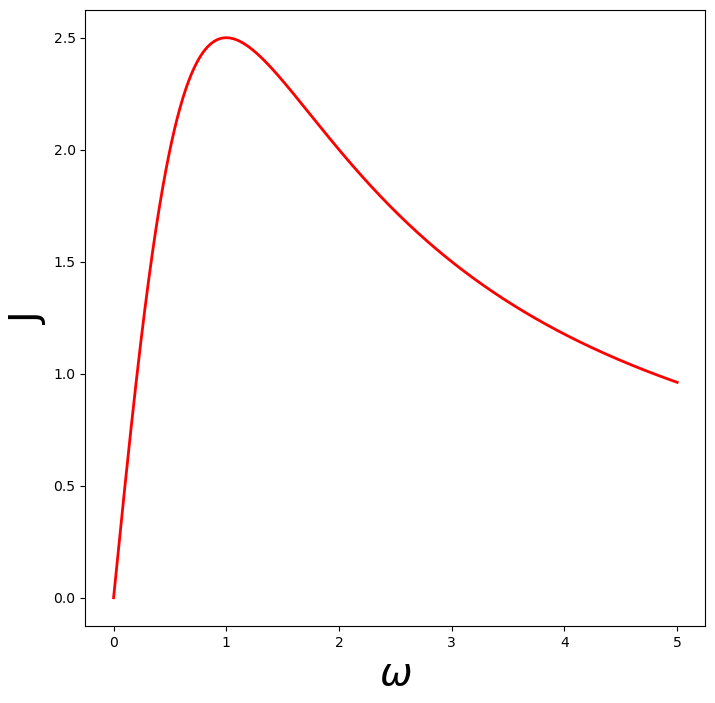

In [9]:
w = np.linspace(0, 5, 1000)
J = w * 2 * lam * gamma / ((gamma**2 + w**2))

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
axes.plot(w, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28);

## Simulation 1: Matsubara decomposition, not using Ishizaki-Tanimura terminator

In [10]:
with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOMMats = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.018421173095703125
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 Total run time:   0.40s
ODE solver time: 0.4025256633758545


## Simulation 2: Matsubara decomposition (including terminator)

In [11]:
with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    _, terminator = bath.terminator()
    Ltot = liouvillian(Hsys) + terminator
    HEOMMatsT = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

RHS construction time: 0.018275022506713867


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.39s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.40s / Remaining 00:00:00:00

 Total run time:   0.40s
ODE solver time: 0.4051828384399414


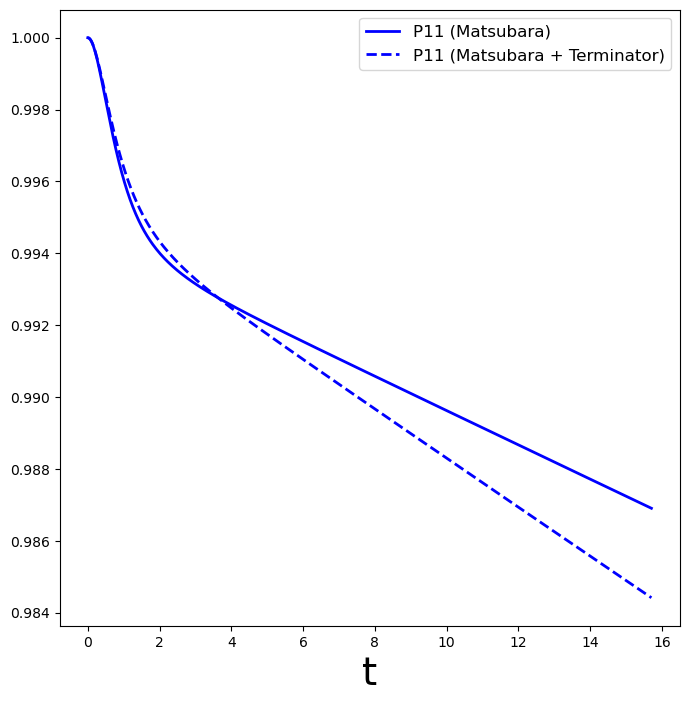

In [12]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

P11_mats = np.real(expect(resultMats.states, P11p))
axes.plot(
    tlist, np.real(P11_mats),
    'b', linewidth=2, label="P11 (Matsubara)",
)

P11_matsT = np.real(expect(resultMatsT.states, P11p))
axes.plot(
    tlist, np.real(P11_matsT),
    'b--', linewidth=2,
    label="P11 (Matsubara + Terminator)",
)

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12);

## Simulation 3: Pade decomposition

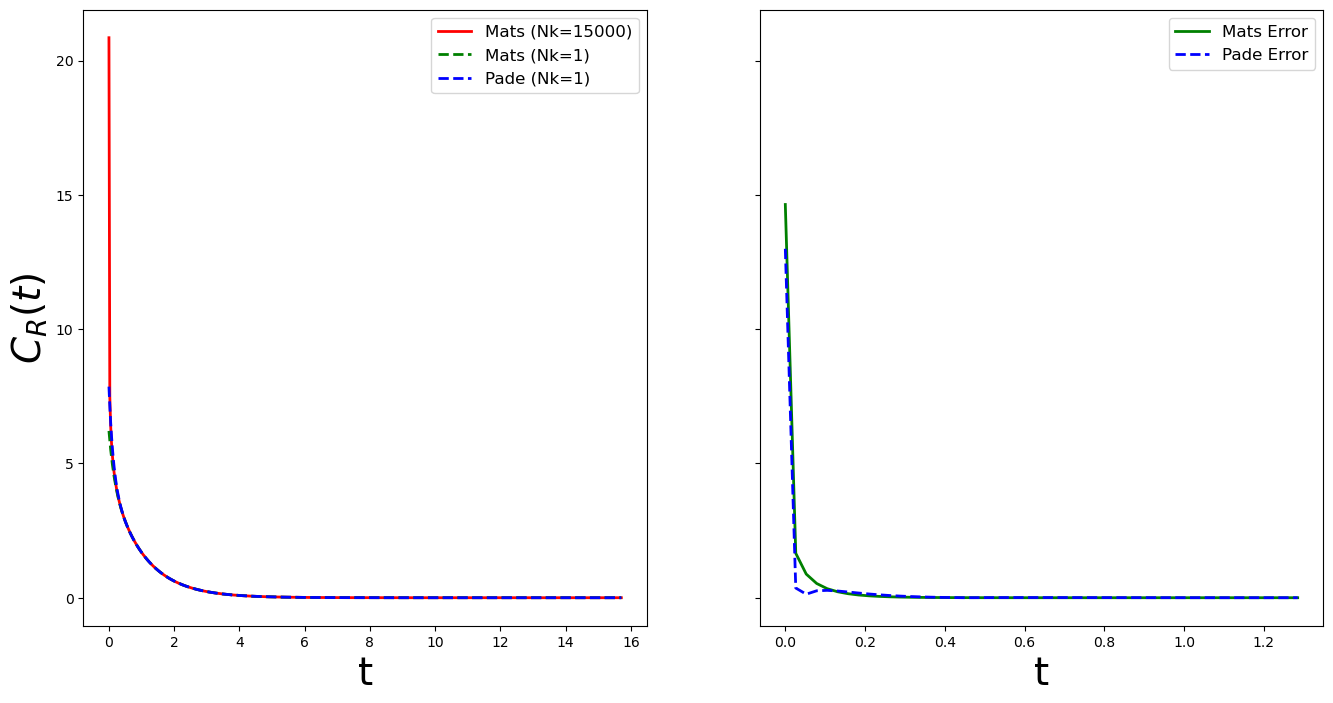

In [13]:
# First, compare Matsubara and Pade decompositions
matsBath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
padeBath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)

# We will compare against a summation of {lmaxmats} Matsubara terms
lmaxmats = 15000
exactBath = DrudeLorentzBath(
    Q, lam=lam, gamma=gamma, T=T, Nk=lmaxmats, combine=False,
)


def CR(bath, t):
    """ C_R, the real part of the correlation function. """
    result = 0
    for exp in bath.exponents:
        if (
            exp.type == BathExponent.types['R'] or
            exp.type == BathExponent.types['RI']
        ):
            result += exp.ck * np.exp(-exp.vk * t)
    return result


def CI(bath, t):
    """ C_I, the imaginary part of the correlation function. """
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['I']:
            result += exp.ck * np.exp(exp.vk * t)
        if exp.type == BathExponent.types['RI']:
            result += exp.ck2 * np.exp(exp.vk * t)
    return result


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 8))

ax1.plot(
    tlist, CR(exactBath, tlist),
    "r", linewidth=2, label=f"Mats (Nk={lmaxmats})",
)
ax1.plot(
    tlist, CR(matsBath, tlist),
    "g--", linewidth=2, label=f"Mats (Nk={Nk})",
)
ax1.plot(
    tlist, CR(padeBath, tlist),
    "b--", linewidth=2, label=f"Pade (Nk={Nk})",
)

ax1.set_xlabel(r't', fontsize=28)
ax1.set_ylabel(r"$C_R(t)$", fontsize=28)
ax1.legend(loc=0, fontsize=12)

tlist2 = tlist[0:50]
ax2.plot(
    tlist2, np.abs(CR(matsBath, tlist2) - CR(exactBath, tlist2)),
    "g", linewidth=2, label="Mats Error",
)
ax2.plot(
    tlist2, np.abs(CR(padeBath, tlist2) - CR(exactBath, tlist2)),
    "b--", linewidth=2, label="Pade Error",
)

ax2.set_xlabel(r't', fontsize=28)
ax2.legend(loc=0, fontsize=12);

In [14]:
with timer("RHS construction time"):
    bath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOMPade = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultPade = HEOMPade.run(rho0, tlist)

RHS construction time: 0.018260478973388672
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.41s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.42s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.42s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.42s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.42s / Remaining 00:00:00:00

 Total run time:   0.42s
ODE solver time: 0.41788268089294434


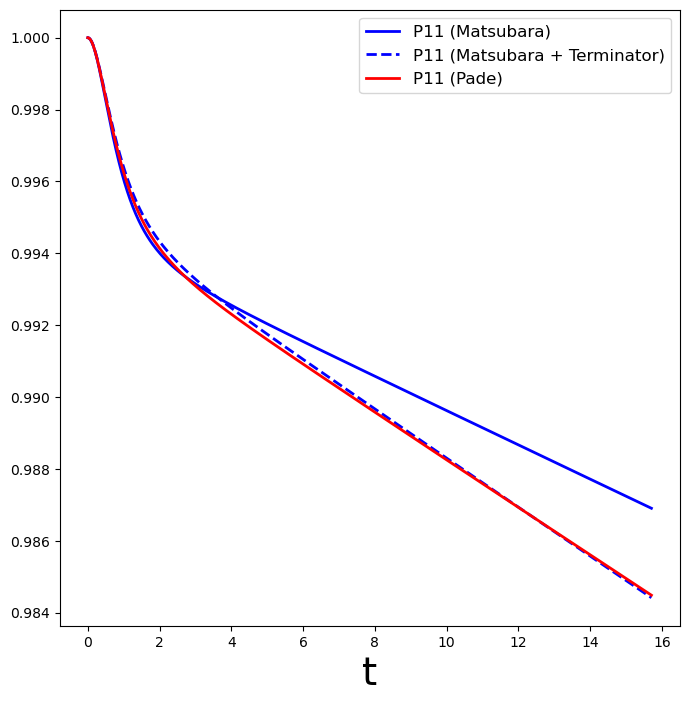

In [15]:
# Plot the results
fig, axes = plt.subplots(figsize=(8, 8))

axes.plot(
    tlist, np.real(P11_mats),
    'b', linewidth=2, label="P11 (Matsubara)",
)
axes.plot(
    tlist, np.real(P11_matsT),
    'b--', linewidth=2, label="P11 (Matsubara + Terminator)",
)

P11_pade = np.real(expect(resultPade.states, P11p))
axes.plot(
    tlist, np.real(P11_pade),
    'r', linewidth=2, label="P11 (Pade)",
)

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12);

## Simulation 4: Fitting approach

In [16]:
def wrapper_fit_func(x, N, args):
    """ Fit function wrapper that unpacks its arguments. """
    x = np.array(x)
    a = np.array(args[:N])
    b = np.array(args[N:2 * N])
    return fit_func(x, a, b)


def fit_func(x, a, b):
    """ Fit function. Calculates the value of the
        correlation function at each x, given the
        fit parameters in a and b.
    """
    return np.sum(
        a[:, None] * np.exp(np.multiply.outer(b, x)),
        axis=0,
    )


def fitter(ans, tlist, k):
    """ Compute fit with k exponents. """
    upper_a = abs(max(ans, key=abs)) * 10
    # sets initial guesses:
    guess = (
        [upper_a / k] * k +  # guesses for a
        [0] * k  # guesses for b
    )
    # sets lower bounds:
    b_lower = (
        [-upper_a] * k +  # lower bounds for a
        [-np.inf] * k  # lower bounds for b
    )
    # sets higher bounds:
    b_higher = (
        [upper_a] * k +  # upper bounds for a
        [0] * k  # upper bounds for b
    )
    param_bounds = (b_lower, b_higher)
    p1, p2 = curve_fit(
        lambda x, *params_0: wrapper_fit_func(x, k, params_0),
        tlist,
        ans,
        p0=guess,
        sigma=[0.01 for t in tlist],
        bounds=param_bounds,
        maxfev=1e8,
    )
    a, b = p1[:k], p1[k:]
    return (a, b)

In [17]:
# Fitting the real part of the correlation function:

# Correlation function values to fit:
tlist_fit = np.linspace(0, 6, 10000)
corrRana = CR(exactBath, tlist_fit)

# Perform the fit:
kR = 3  # number of exponents to use for real part
poptR = []
with timer("Correlation (real) fitting time"):
    for i in range(kR):
        poptR.append(fitter(corrRana, tlist_fit, i + 1))

Correlation (real) fitting time: 0.13312530517578125


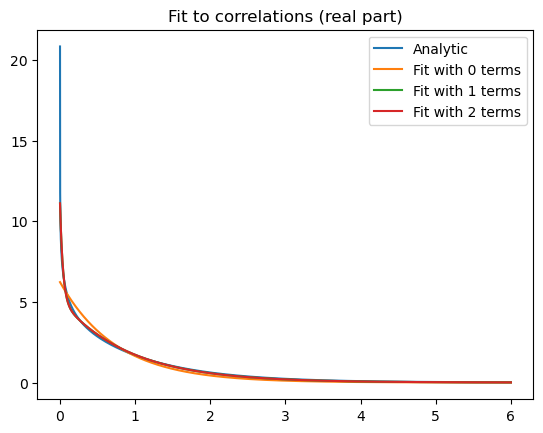

In [18]:
plt.plot(tlist_fit, corrRana, label="Analytic")

for i in range(kR):
    y = fit_func(tlist_fit, *poptR[i])
    plt.plot(tlist_fit, y, label=f"Fit with {i} terms")

plt.title("Fit to correlations (real part)")
plt.legend()
plt.show()

In [19]:
# Set the exponential coefficients from the fit parameters

ckAR1 = poptR[-1][0]
ckAR = [x + 0j for x in ckAR1]

vkAR1 = poptR[-1][1]
vkAR = [-x + 0j for x in vkAR1]

# Imaginary part: use analytical value

ckAI = [lam * gamma * (-1.0) + 0j]
vkAI = [gamma + 0j]

In [20]:
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    # We reduce NC slightly here for speed of execution because we retain
    # 3 exponents in ckAR instead of 1. Please restore full NC for
    # convergence though:
    HEOMFit = HEOMSolver(Hsys, bath, int(NC * 0.7), options=options)

with timer("ODE solver time"):
    resultFit = HEOMFit.run(rho0, tlist)

RHS construction time: 0.07851791381835938


 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:04

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.33s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.33s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.33s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.33s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.34s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.35s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.35s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.35s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.35s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.36s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.36s / Remaining 00:00:00:00

 Total run time:   1.36s
ODE solver time: 1.3584363460540771


## Simulation 5: Bloch-Redfield

In [21]:
DL = (
    "2 * pi * 2.0 * {lam} / (pi * {gamma} * {beta}) if (w==0) "
    "else 2 * pi * (2.0 * {lam} * {gamma} * w / (pi * (w**2 + {gamma}**2))) "
    "* ((1 / (exp(w * {beta}) - 1)) + 1)"
).format(gamma=gamma, beta=beta, lam=lam)

with timer("ODE solver time"):
    resultBR = brmesolve(
        Hsys, rho0, tlist,
        a_ops=[[sigmaz(), DL]], sec_cutoff=0, options=options,
    )

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.15s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.20s / Remaining 00:00:00:00

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/coefficient.py:420: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


 [*********70%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.28s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.28s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.28s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.28s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.28s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.29s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.29s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.29s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.29s / Remaining 00:00:00:00

 Total run time:   0.29s
ODE solver time: 0.2919301986694336


## Let's plot all our results

Finally, let's plot all of our different results to see how they shape up against each other.

In [22]:
# Calculate expectation values in the bases:
P11_mats = np.real(expect(resultMats.states, P11p))
P11_matsT = np.real(expect(resultMatsT.states, P11p))
P11_pade = np.real(expect(resultPade.states, P11p))
P11_fit = np.real(expect(resultFit.states, P11p))
P11_br = np.real(expect(resultBR.states, P11p))

In [23]:
rcParams = {
    "axes.titlesize": 25,
    "axes.labelsize": 30,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 28,
    "axes.grid": False,
    "savefig.bbox": "tight",
    "lines.markersize": 5,
    "font.family": "STIXgeneral",
    "mathtext.fontset": "stix",
    "font.serif": "STIX",
    "text.usetex": False,
}

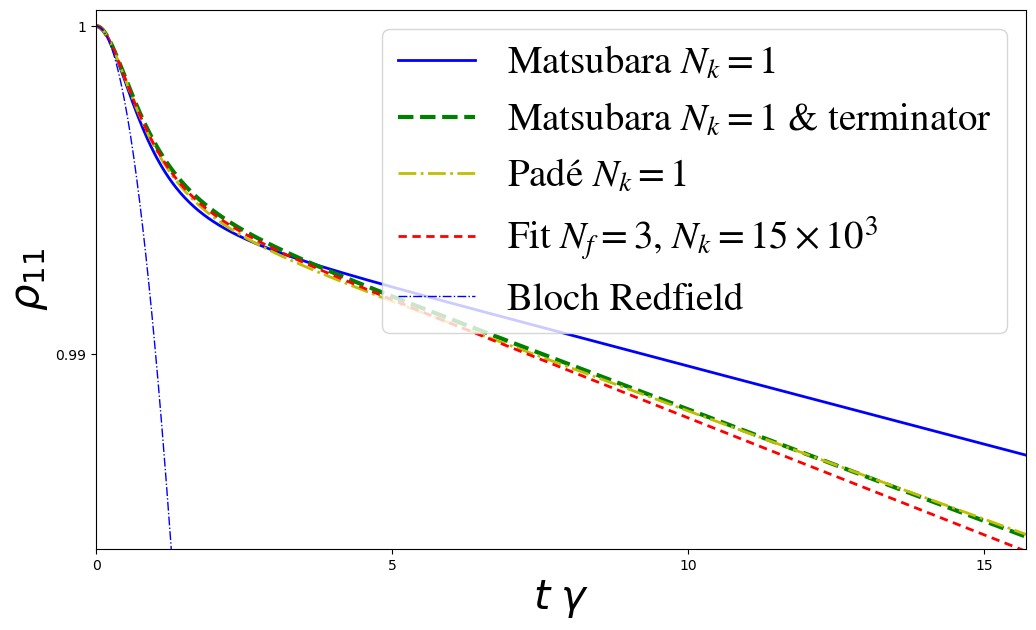

In [24]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

with plt.rc_context(rcParams):
    # Plot the results
    plt.yticks([0.99, 1.0], [0.99, 1])
    axes.plot(
        tlist, np.real(P11_mats),
        'b', linewidth=2, label=f"Matsubara $N_k={Nk}$",
    )
    axes.plot(
        tlist, np.real(P11_matsT),
        'g--', linewidth=3,
        label=f"Matsubara $N_k={Nk}$ & terminator",
    )
    axes.plot(
        tlist, np.real(P11_pade),
        'y-.', linewidth=2, label=f"Padé $N_k={Nk}$",
    )
    axes.plot(
        tlist, np.real(P11_fit),
        'r', dashes=[3, 2], linewidth=2,
        label=r"Fit $N_f = 3$, $N_k=15 \times 10^3$",
    )
    axes.plot(
        tlist, np.real(P11_br),
        'b-.', linewidth=1, label="Bloch Redfield",
    )

    axes.locator_params(axis='y', nbins=6)
    axes.locator_params(axis='x', nbins=6)
    axes.set_ylabel(r'$\rho_{11}$', fontsize=30)
    axes.set_xlabel(r'$t\;\gamma$', fontsize=30)
    axes.set_xlim(tlist[0], tlist[-1])
    axes.set_ylim(0.98405, 1.0005)
    axes.legend(loc=0)

## About

In [25]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [26]:
assert np.allclose(P11_matsT, P11_pade, rtol=1e-3)
assert np.allclose(P11_matsT, P11_fit, rtol=1e-3)